### <font color='orange'>Importing libraries:</font>

In [ ]:
import numpy as np
from numpy import ones, zeros
import matplotlib.pyplot as plt
from keras.datasets.cifar10 import load_data
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose, Input, Embedding, Concatenate
from keras.utils.vis_utils import plot_model
from numpy.random import randint, rand, randn
from IPython.display import clear_output, display
from keras.models import load_model
from google.colab import files

### <font color='orange'>Loading cifar10 dataset:</font>

First we load the cifar10 dataset and then summarize the shape of dataset.

In [ ]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


### <font color='orange'>Plotting 49 images:</font>

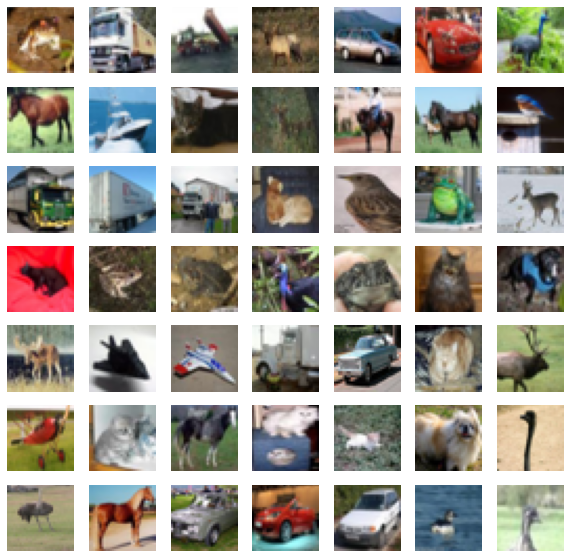

In [ ]:
# plot images from the training dataset
plt.figure(figsize=(10, 10))
for i in range(49):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i])
plt.show()

### <font color='orange'>Creating Discriminator function:</font>

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 50)        500         input_21[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 1, 1024)      52224       embedding_11[0][0]               
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 32, 32, 3)    0                                            
___________________________________________________________________________________________

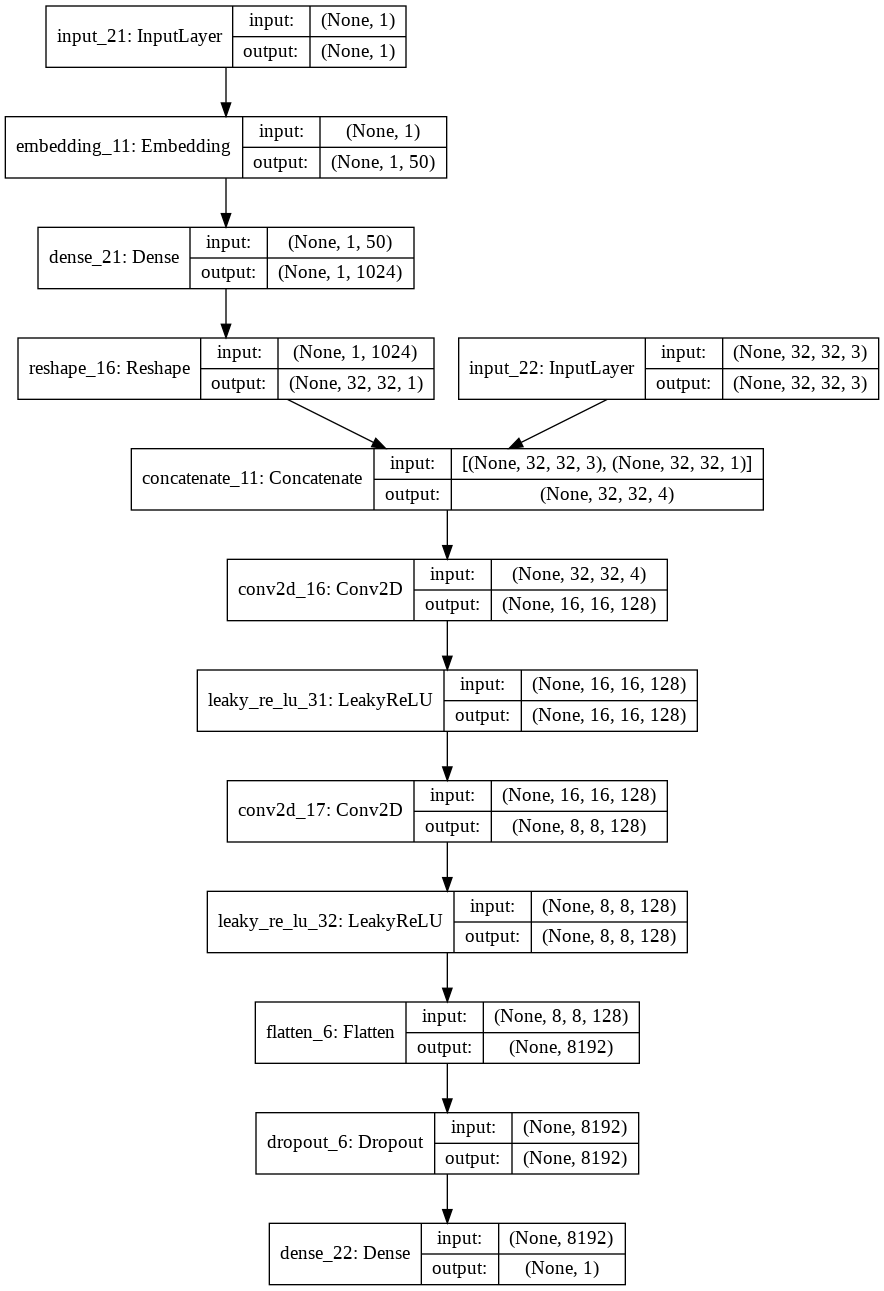

In [ ]:
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## <font color='orange'>Generator function:</font>

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 4 * 4
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((4, 4, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((4, 4, 256))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 8x8
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 4096)         413696      input_24[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        500         input_23[0][0]                   
___________________________________________________________________________________________

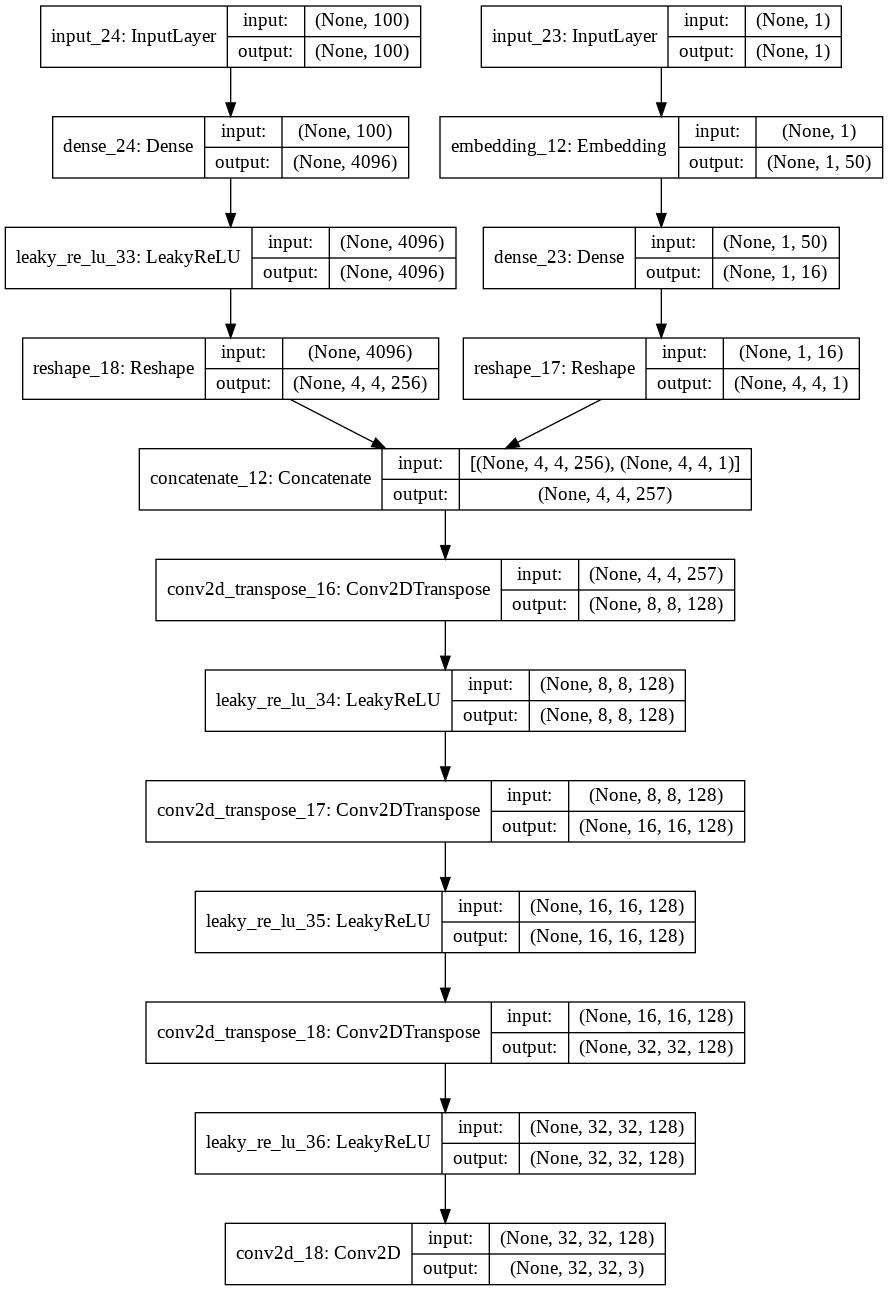

In [ ]:
# define the size of the latent space
latent_dim = 100
# define the generator model
gen_model = define_generator(latent_dim)
# summarize the model
gen_model.summary()
# plot the model
plot_model(gen_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

### <font color='orange'>Defining combined GAN: </font>

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 4096)         413696      input_28[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 50)        500         input_27[0][0]                   
___________________________________________________________________________________________

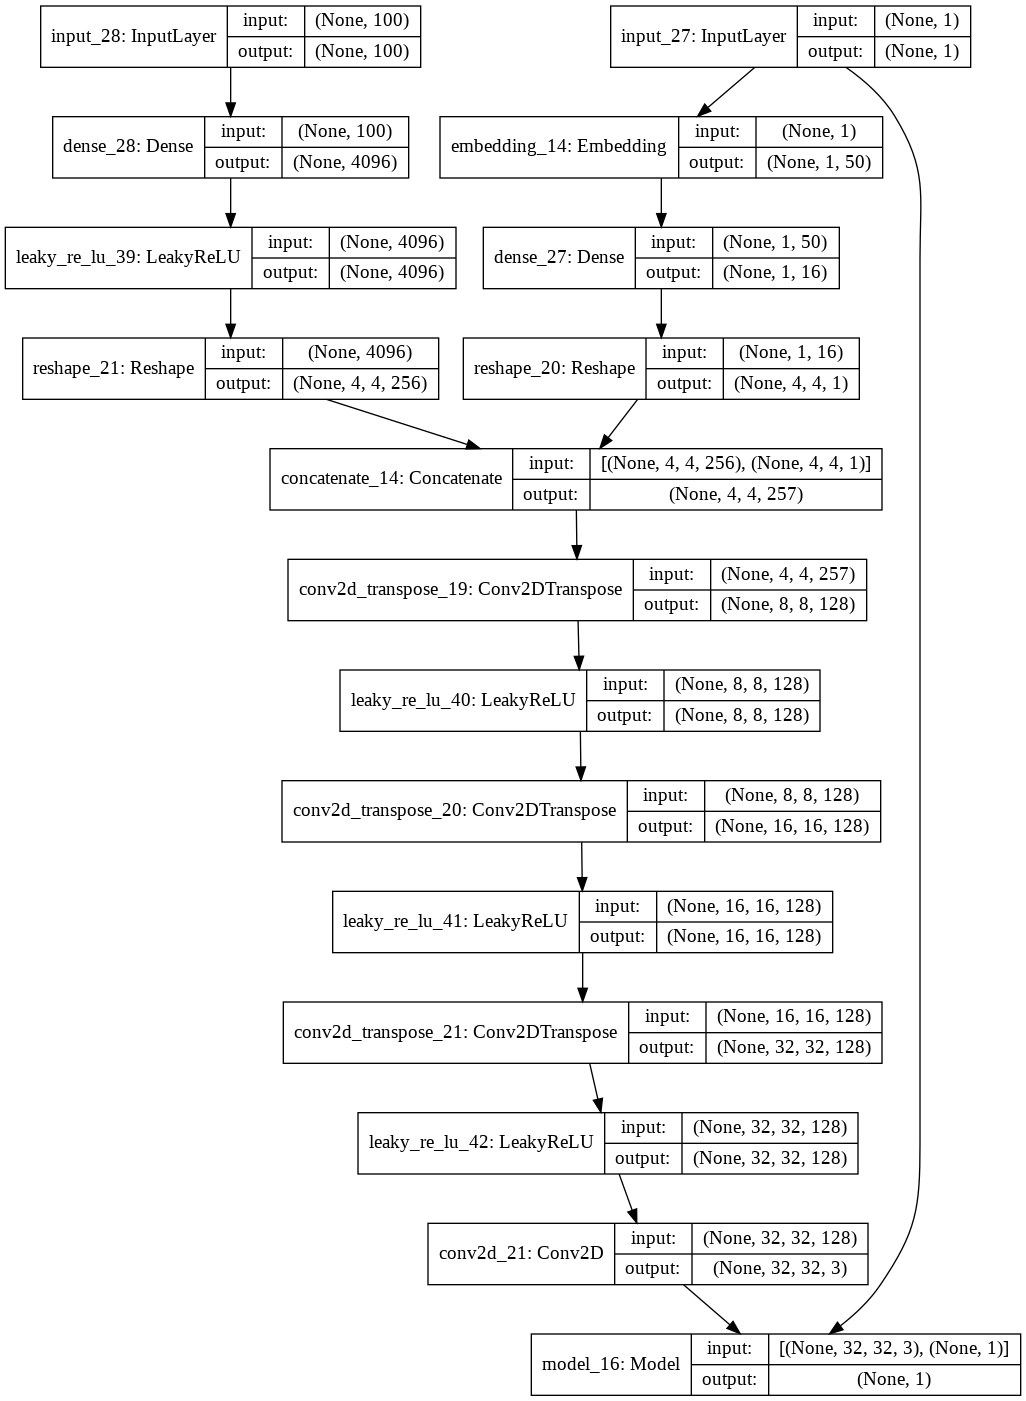

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

### <font color='orange'>The *load_real_samples()* function below implements the loading and scaling of real CIFAR-10 photographs:</font>

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# convert from ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

### <font color='orange'>We define two functions to generate real and fake images:</font>

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

## <font color='orange'>Training function:</font>

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    fig = plt.figure(figsize=(n, n))
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    #plt.close()
    plt.show()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=300):
    # prepare real samples
    [X_real, labels_real], y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate([X_real, labels_real], y_real, verbose=0)
    # prepare fake examples
    [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate([X_fake, labels], y_fake, verbose=0)
    if epoch % 20 == 0:
        # summarize discriminator performance
        print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
        # save plot
        save_plot(X_fake, epoch)
        # save the generator model tile file
        filename = 'generator_model_%03d.h5' % (epoch+1)
        g_model.save(filename)
        
    return acc_real, acc_fake

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    dis_loss = np.zeros(bat_per_epo * n_epochs)
    gen_loss = np.zeros(bat_per_epo * n_epochs)
    accuracy_real = np.zeros(n_epochs)
    accuracy_fake = np.zeros(n_epochs)
    half_batch = int(n_batch / 2)
	# manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # Sum of two losses
            d_loss_tot = d_loss1 + d_loss2
            dis_loss[i*bat_per_epo+j] = d_loss_tot
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            gen_loss[i*bat_per_epo+j] = g_loss
            # summarize loss on this batch
        print('epoch %d finished, %d/%d, d1=%.3f, d2=%.3f g=%.3f'%
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        acc_real, acc_fake = summarize_performance(i, g_model, d_model, dataset, latent_dim)
        accuracy_real[i] = acc_real
        accuracy_fake[i] = acc_fake

    # save the generator model
    g_model.save('cgan_generator.h5')
    return dis_loss, gen_loss, accuracy_real, accuracy_fake

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


epoch 1 finished, 390/390, d1=0.516, d2=0.626 g=0.877
Accuracy real: 70%, fake: 67%


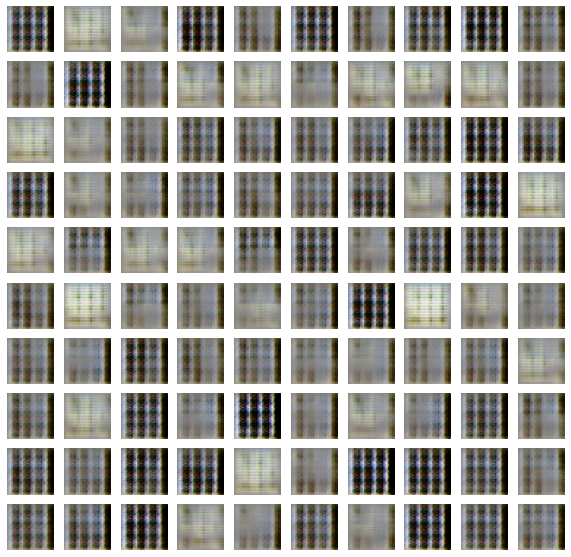

epoch 2 finished, 390/390, d1=0.690, d2=0.664 g=0.809
epoch 3 finished, 390/390, d1=0.586, d2=0.572 g=0.970
epoch 4 finished, 390/390, d1=0.670, d2=0.744 g=0.740
epoch 5 finished, 390/390, d1=0.680, d2=0.830 g=0.653
epoch 6 finished, 390/390, d1=0.676, d2=0.631 g=0.832
epoch 7 finished, 390/390, d1=0.741, d2=0.659 g=0.848
epoch 8 finished, 390/390, d1=0.707, d2=0.557 g=0.976
epoch 9 finished, 390/390, d1=0.674, d2=0.608 g=0.965
epoch 10 finished, 390/390, d1=0.765, d2=0.557 g=1.061
epoch 11 finished, 390/390, d1=0.763, d2=0.629 g=0.846
epoch 12 finished, 390/390, d1=0.681, d2=0.690 g=0.743
epoch 13 finished, 390/390, d1=0.701, d2=0.674 g=0.832
epoch 14 finished, 390/390, d1=0.716, d2=0.663 g=0.879
epoch 15 finished, 390/390, d1=0.686, d2=0.701 g=0.756
epoch 16 finished, 390/390, d1=0.681, d2=0.697 g=0.763
epoch 17 finished, 390/390, d1=0.702, d2=0.713 g=0.800
epoch 18 finished, 390/390, d1=0.681, d2=0.684 g=0.776
epoch 19 finished, 390/390, d1=0.749, d2=0.689 g=0.818
epoch 20 finished,

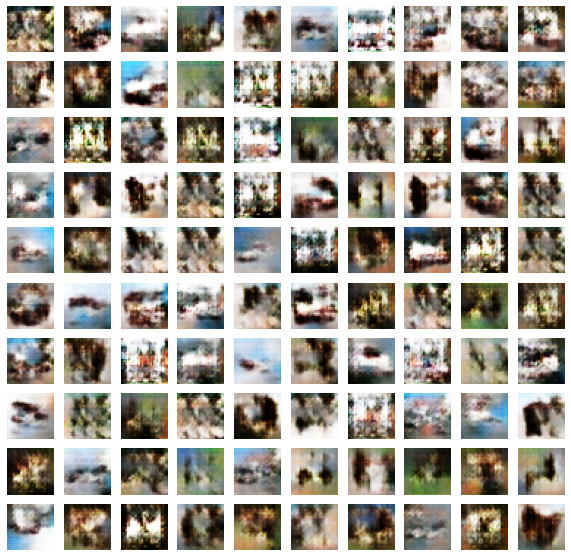

epoch 22 finished, 390/390, d1=0.700, d2=0.652 g=0.767
epoch 23 finished, 390/390, d1=0.648, d2=0.723 g=0.744
epoch 24 finished, 390/390, d1=0.697, d2=0.698 g=0.787
epoch 25 finished, 390/390, d1=0.661, d2=0.713 g=0.773
epoch 26 finished, 390/390, d1=0.664, d2=0.657 g=0.807
epoch 27 finished, 390/390, d1=0.686, d2=0.655 g=0.811
epoch 28 finished, 390/390, d1=0.704, d2=0.661 g=0.734
epoch 29 finished, 390/390, d1=0.699, d2=0.688 g=0.757
epoch 30 finished, 390/390, d1=0.694, d2=0.645 g=0.758
epoch 31 finished, 390/390, d1=0.704, d2=0.718 g=0.765
epoch 32 finished, 390/390, d1=0.674, d2=0.674 g=0.743
epoch 33 finished, 390/390, d1=0.700, d2=0.692 g=0.705
epoch 34 finished, 390/390, d1=0.669, d2=0.742 g=0.730
epoch 35 finished, 390/390, d1=0.714, d2=0.708 g=0.720
epoch 36 finished, 390/390, d1=0.655, d2=0.650 g=0.799
epoch 37 finished, 390/390, d1=0.715, d2=0.686 g=0.736
epoch 38 finished, 390/390, d1=0.703, d2=0.695 g=0.749
epoch 39 finished, 390/390, d1=0.694, d2=0.684 g=0.710
epoch 40 f

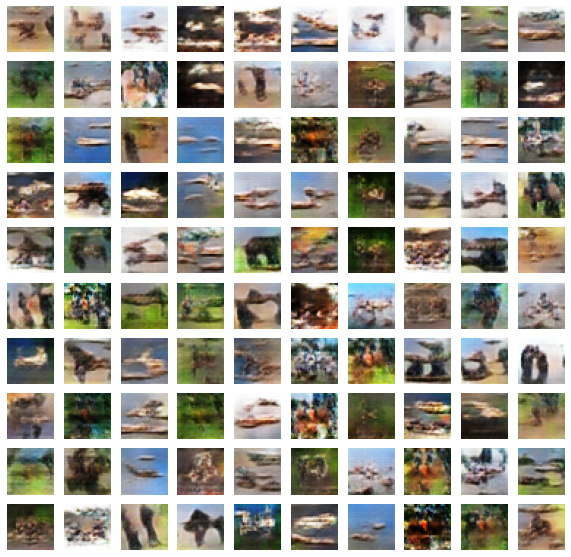

epoch 42 finished, 390/390, d1=0.691, d2=0.666 g=0.743
epoch 43 finished, 390/390, d1=0.695, d2=0.668 g=0.749
epoch 44 finished, 390/390, d1=0.688, d2=0.659 g=0.751
epoch 45 finished, 390/390, d1=0.688, d2=0.722 g=0.706
epoch 46 finished, 390/390, d1=0.710, d2=0.763 g=0.712
epoch 47 finished, 390/390, d1=0.683, d2=0.687 g=0.722
epoch 48 finished, 390/390, d1=0.683, d2=0.715 g=0.714
epoch 49 finished, 390/390, d1=0.711, d2=0.705 g=0.723
epoch 50 finished, 390/390, d1=0.681, d2=0.701 g=0.712
epoch 51 finished, 390/390, d1=0.670, d2=0.682 g=0.817
epoch 52 finished, 390/390, d1=0.705, d2=0.705 g=0.719
epoch 53 finished, 390/390, d1=0.696, d2=0.719 g=0.700
epoch 54 finished, 390/390, d1=0.702, d2=0.688 g=0.720
epoch 55 finished, 390/390, d1=0.704, d2=0.685 g=0.706
epoch 56 finished, 390/390, d1=0.680, d2=0.677 g=0.747
epoch 57 finished, 390/390, d1=0.688, d2=0.701 g=0.701
epoch 58 finished, 390/390, d1=0.701, d2=0.694 g=0.706
epoch 59 finished, 390/390, d1=0.702, d2=0.679 g=0.724
epoch 60 f

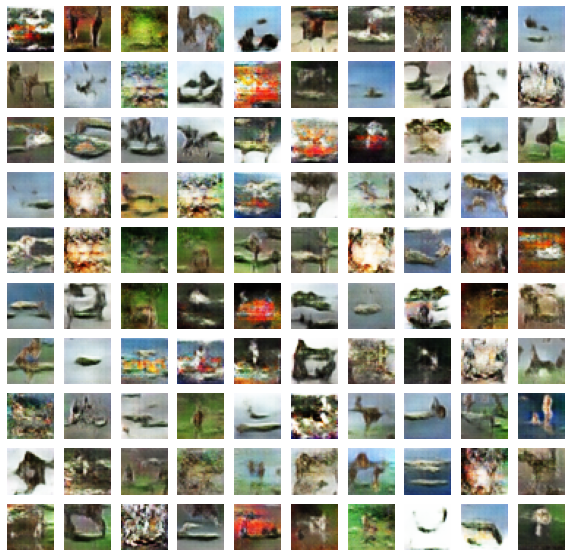

epoch 62 finished, 390/390, d1=0.674, d2=0.684 g=0.712
epoch 63 finished, 390/390, d1=0.696, d2=0.703 g=0.707
epoch 64 finished, 390/390, d1=0.682, d2=0.697 g=0.718
epoch 65 finished, 390/390, d1=0.689, d2=0.673 g=0.732
epoch 66 finished, 390/390, d1=0.692, d2=0.682 g=0.730
epoch 67 finished, 390/390, d1=0.687, d2=0.700 g=0.703
epoch 68 finished, 390/390, d1=0.684, d2=0.695 g=0.722
epoch 69 finished, 390/390, d1=0.703, d2=0.688 g=0.731
epoch 70 finished, 390/390, d1=0.703, d2=0.697 g=0.710
epoch 71 finished, 390/390, d1=0.689, d2=0.676 g=0.696
epoch 72 finished, 390/390, d1=0.698, d2=0.680 g=0.719
epoch 73 finished, 390/390, d1=0.706, d2=0.676 g=0.721
epoch 74 finished, 390/390, d1=0.704, d2=0.693 g=0.718
epoch 75 finished, 390/390, d1=0.691, d2=0.677 g=0.742
epoch 76 finished, 390/390, d1=0.696, d2=0.693 g=0.706
epoch 77 finished, 390/390, d1=0.697, d2=0.684 g=0.719
epoch 78 finished, 390/390, d1=0.697, d2=0.710 g=0.714
epoch 79 finished, 390/390, d1=0.694, d2=0.720 g=0.713
epoch 80 f

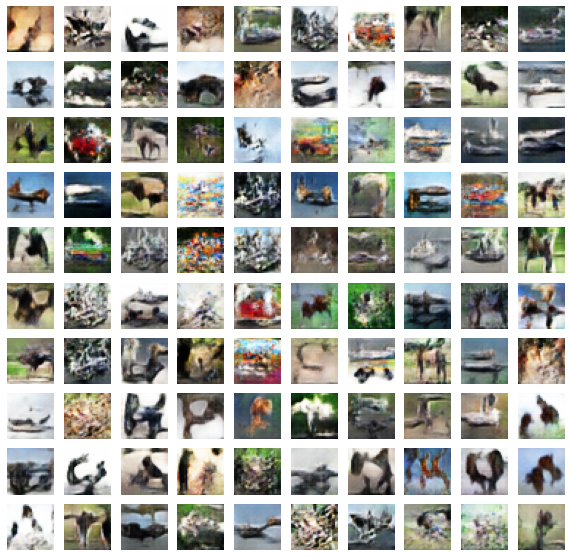

epoch 82 finished, 390/390, d1=0.699, d2=0.698 g=0.706
epoch 83 finished, 390/390, d1=0.681, d2=0.697 g=0.693
epoch 84 finished, 390/390, d1=0.716, d2=0.682 g=0.712
epoch 85 finished, 390/390, d1=0.689, d2=0.683 g=0.712
epoch 86 finished, 390/390, d1=0.696, d2=0.781 g=0.693
epoch 87 finished, 390/390, d1=0.684, d2=0.684 g=0.701
epoch 88 finished, 390/390, d1=0.700, d2=0.697 g=0.696
epoch 89 finished, 390/390, d1=0.688, d2=0.687 g=0.710
epoch 90 finished, 390/390, d1=0.697, d2=0.692 g=0.704
epoch 91 finished, 390/390, d1=0.695, d2=0.691 g=0.706
epoch 92 finished, 390/390, d1=0.700, d2=0.675 g=0.719
epoch 93 finished, 390/390, d1=0.698, d2=0.702 g=0.707
epoch 94 finished, 390/390, d1=0.697, d2=0.683 g=0.718
epoch 95 finished, 390/390, d1=0.683, d2=0.711 g=0.702
epoch 96 finished, 390/390, d1=0.691, d2=0.693 g=0.711
epoch 97 finished, 390/390, d1=0.697, d2=0.676 g=0.716
epoch 98 finished, 390/390, d1=0.695, d2=0.692 g=0.708
epoch 99 finished, 390/390, d1=0.690, d2=0.694 g=0.705
epoch 100 

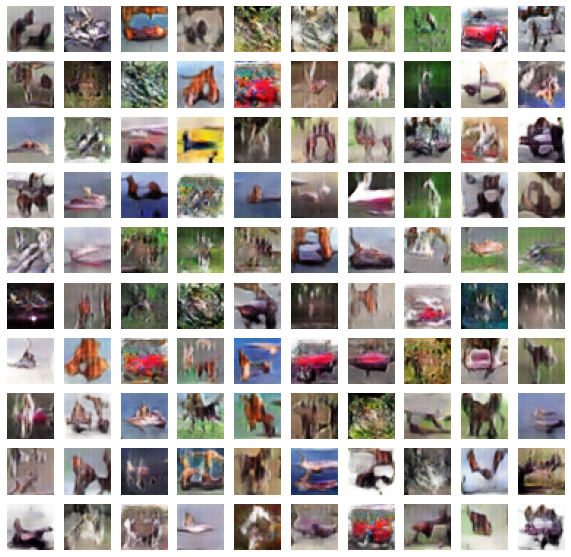

epoch 102 finished, 390/390, d1=0.699, d2=0.695 g=0.716
epoch 103 finished, 390/390, d1=0.689, d2=0.691 g=0.701
epoch 104 finished, 390/390, d1=0.698, d2=0.711 g=0.702
epoch 105 finished, 390/390, d1=0.696, d2=0.705 g=0.704
epoch 106 finished, 390/390, d1=0.686, d2=0.704 g=0.694
epoch 107 finished, 390/390, d1=0.690, d2=0.681 g=0.714
epoch 108 finished, 390/390, d1=0.711, d2=0.698 g=0.733
epoch 109 finished, 390/390, d1=0.696, d2=0.693 g=0.697
epoch 110 finished, 390/390, d1=0.693, d2=0.704 g=0.696
epoch 111 finished, 390/390, d1=0.705, d2=0.677 g=0.711
epoch 112 finished, 390/390, d1=0.693, d2=0.692 g=0.706
epoch 113 finished, 390/390, d1=0.707, d2=0.689 g=0.706
epoch 114 finished, 390/390, d1=0.693, d2=0.688 g=0.707
epoch 115 finished, 390/390, d1=0.699, d2=0.685 g=0.706
epoch 116 finished, 390/390, d1=0.682, d2=0.698 g=0.687
epoch 117 finished, 390/390, d1=0.707, d2=0.647 g=0.792
epoch 118 finished, 390/390, d1=0.698, d2=0.688 g=0.710
epoch 119 finished, 390/390, d1=0.703, d2=0.680 

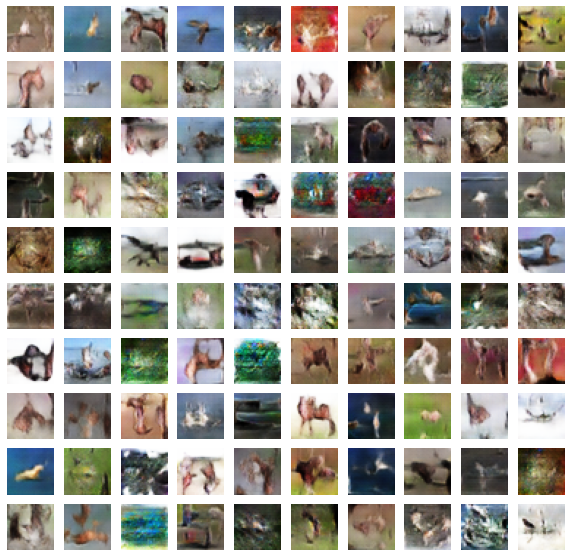

epoch 122 finished, 390/390, d1=0.696, d2=0.704 g=0.709
epoch 123 finished, 390/390, d1=0.698, d2=0.695 g=0.707
epoch 124 finished, 390/390, d1=0.696, d2=0.686 g=0.708
epoch 125 finished, 390/390, d1=0.695, d2=0.697 g=0.708
epoch 126 finished, 390/390, d1=0.699, d2=0.685 g=0.717
epoch 127 finished, 390/390, d1=0.685, d2=0.692 g=0.713
epoch 128 finished, 390/390, d1=0.691, d2=0.687 g=0.707
epoch 129 finished, 390/390, d1=0.691, d2=0.696 g=0.697
epoch 130 finished, 390/390, d1=0.699, d2=0.699 g=0.720
epoch 131 finished, 390/390, d1=0.700, d2=0.694 g=0.701
epoch 132 finished, 390/390, d1=0.700, d2=0.693 g=0.709
epoch 133 finished, 390/390, d1=0.700, d2=0.691 g=0.718
epoch 134 finished, 390/390, d1=0.708, d2=0.680 g=0.711
epoch 135 finished, 390/390, d1=0.696, d2=0.696 g=0.696
epoch 136 finished, 390/390, d1=0.698, d2=0.684 g=0.716
epoch 137 finished, 390/390, d1=0.702, d2=0.688 g=0.703
epoch 138 finished, 390/390, d1=0.694, d2=0.697 g=0.715
epoch 139 finished, 390/390, d1=0.695, d2=0.708 

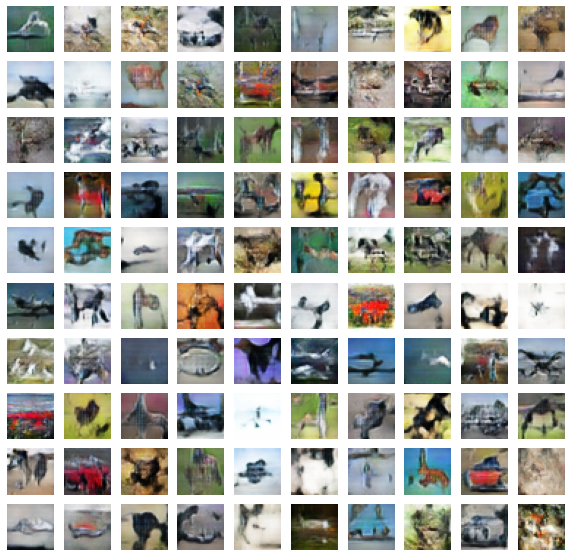

epoch 142 finished, 390/390, d1=0.704, d2=0.687 g=0.699
epoch 143 finished, 390/390, d1=0.685, d2=0.698 g=0.696
epoch 144 finished, 390/390, d1=0.697, d2=0.682 g=0.695
epoch 145 finished, 390/390, d1=0.693, d2=0.687 g=0.709
epoch 146 finished, 390/390, d1=0.702, d2=0.686 g=0.710
epoch 147 finished, 390/390, d1=0.702, d2=0.687 g=0.722
epoch 148 finished, 390/390, d1=0.700, d2=0.679 g=0.707
epoch 149 finished, 390/390, d1=0.695, d2=0.691 g=0.702
epoch 150 finished, 390/390, d1=0.696, d2=0.688 g=0.706
epoch 151 finished, 390/390, d1=0.702, d2=0.691 g=0.708
epoch 152 finished, 390/390, d1=0.688, d2=0.702 g=0.700
epoch 153 finished, 390/390, d1=0.693, d2=0.692 g=0.698
epoch 154 finished, 390/390, d1=0.698, d2=0.685 g=0.706
epoch 155 finished, 390/390, d1=0.693, d2=0.697 g=0.695
epoch 156 finished, 390/390, d1=0.693, d2=0.693 g=0.694
epoch 157 finished, 390/390, d1=0.682, d2=0.706 g=0.710
epoch 158 finished, 390/390, d1=0.694, d2=0.698 g=0.706
epoch 159 finished, 390/390, d1=0.695, d2=0.698 

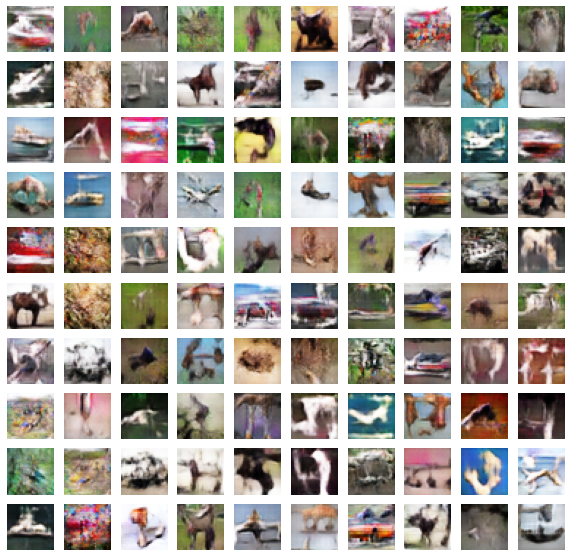

epoch 162 finished, 390/390, d1=0.699, d2=0.693 g=0.710
epoch 163 finished, 390/390, d1=0.693, d2=0.691 g=0.705
epoch 164 finished, 390/390, d1=0.698, d2=0.694 g=0.700
epoch 165 finished, 390/390, d1=0.703, d2=0.687 g=0.708
epoch 166 finished, 390/390, d1=0.693, d2=0.688 g=0.700
epoch 167 finished, 390/390, d1=0.700, d2=0.697 g=0.698
epoch 168 finished, 390/390, d1=0.680, d2=0.690 g=0.697
epoch 169 finished, 390/390, d1=0.696, d2=0.698 g=0.697
epoch 170 finished, 390/390, d1=0.700, d2=0.681 g=0.710
epoch 171 finished, 390/390, d1=0.700, d2=0.693 g=0.698
epoch 172 finished, 390/390, d1=0.704, d2=0.705 g=0.702
epoch 173 finished, 390/390, d1=0.689, d2=0.692 g=0.704
epoch 174 finished, 390/390, d1=0.692, d2=0.702 g=0.696
epoch 175 finished, 390/390, d1=0.695, d2=0.686 g=0.713
epoch 176 finished, 390/390, d1=0.687, d2=0.698 g=0.700
epoch 177 finished, 390/390, d1=0.700, d2=0.707 g=0.695
epoch 178 finished, 390/390, d1=0.693, d2=0.684 g=0.702
epoch 179 finished, 390/390, d1=0.695, d2=0.704 

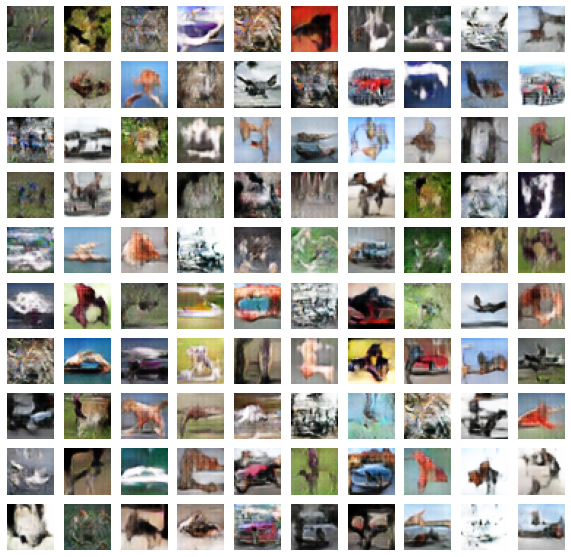

epoch 182 finished, 390/390, d1=0.695, d2=0.691 g=0.702
epoch 183 finished, 390/390, d1=0.695, d2=0.701 g=0.698
epoch 184 finished, 390/390, d1=0.695, d2=0.697 g=0.703
epoch 185 finished, 390/390, d1=0.695, d2=0.696 g=0.701
epoch 186 finished, 390/390, d1=0.701, d2=0.684 g=0.700
epoch 187 finished, 390/390, d1=0.702, d2=0.691 g=0.697
epoch 188 finished, 390/390, d1=0.694, d2=0.690 g=0.704
epoch 189 finished, 390/390, d1=0.688, d2=0.694 g=0.699
epoch 190 finished, 390/390, d1=0.694, d2=0.700 g=0.697
epoch 191 finished, 390/390, d1=0.690, d2=0.682 g=0.704
epoch 192 finished, 390/390, d1=0.694, d2=0.689 g=0.709
epoch 193 finished, 390/390, d1=0.698, d2=0.706 g=0.693
epoch 194 finished, 390/390, d1=0.691, d2=0.697 g=0.695
epoch 195 finished, 390/390, d1=0.704, d2=0.700 g=0.699
epoch 196 finished, 390/390, d1=0.703, d2=0.690 g=0.703
epoch 197 finished, 390/390, d1=0.692, d2=0.694 g=0.701
epoch 198 finished, 390/390, d1=0.694, d2=0.704 g=0.696
epoch 199 finished, 390/390, d1=0.698, d2=0.697 

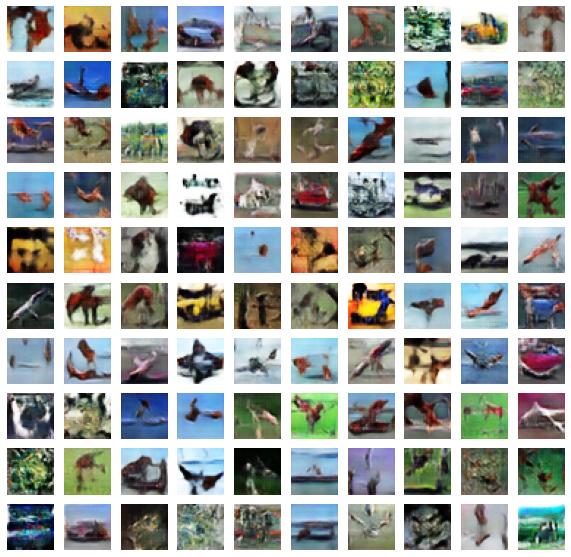

In [ ]:
n_batch = 128
n_epochs = 201
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
dis_loss, gen_loss, accuracy_real, accuracy_fake = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch=128)

Text(0.5, 1.0, "CGAN Model discriminator and generator's Loss")

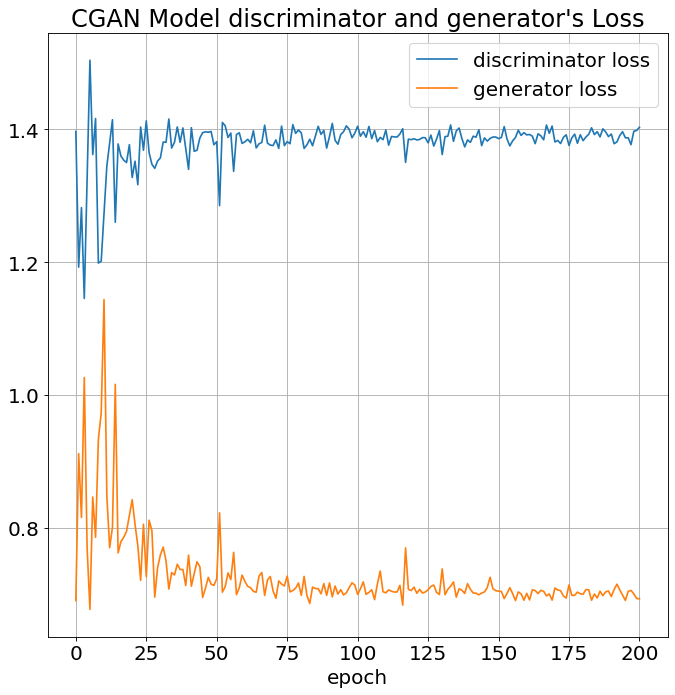

In [ ]:
plot_range = np.arange(201)*390
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

plt.plot(dis_loss[plot_range], label="discriminator loss")
plt.plot(gen_loss[plot_range], label="generator loss")
plt.grid('on')
plt.legend()
plt.xlabel("epoch")
plt.title('CGAN Model discriminator and generator\'s Loss')

Text(0.5, 1.0, 'CGAN Model discriminator accuracy')

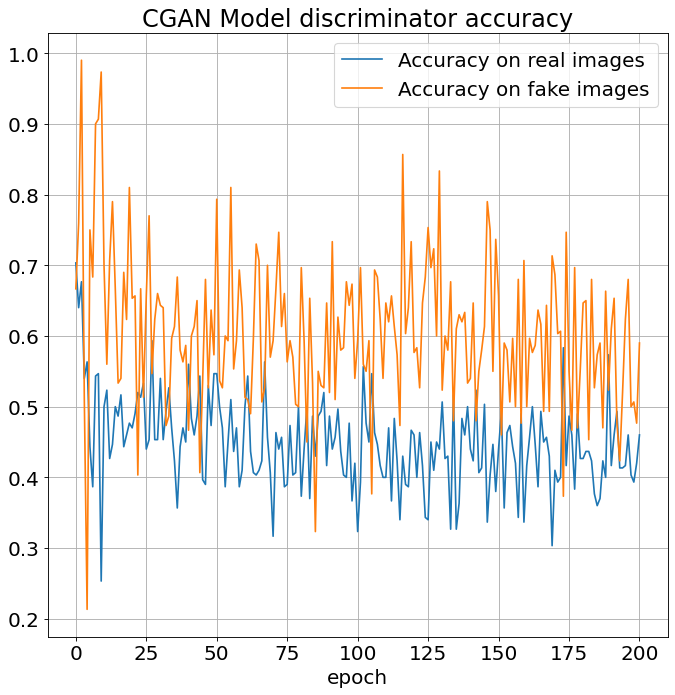

In [ ]:

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(accuracy_real, label="Accuracy on real images")
plt.plot(accuracy_fake, label="Accuracy on fake images")
plt.grid('on')
plt.legend()
plt.xlabel("epoch")
plt.title('CGAN Model discriminator accuracy')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


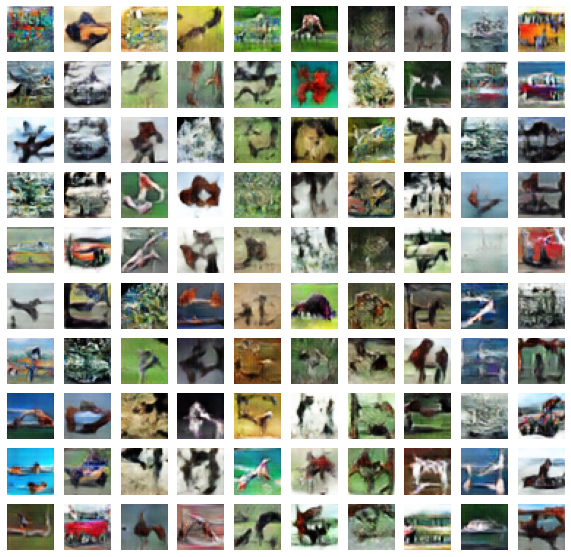

In [ ]:
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# plot the result
save_plot(X, 10)

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 418.67, 16280 MiB
